In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
block_size = 8
batch_size = 32
max_iters = 100000
eval_iters = 250
learning_rate = 1e-4

# Store loss values for plotting
train_losses = []
val_losses = []
iterations = []

cuda


In [2]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
print(chars)
print(len(chars))
vocab_size = len(chars)

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']
81


In [3]:
string_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_string = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])
print(len(data))

tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38, 28,  1, 44, 32, 29,
         1, 47, 33, 50, 25, 42, 28,  1, 33, 38,  1, 39, 50,  0,  0,  1,  1, 26,
        49,  0,  0,  1,  1, 36, 11,  1, 30, 42, 25, 38, 35,  1, 26, 25, 45, 37,
         0,  0,  1,  1, 25, 45, 44, 32, 39, 42,  1, 39, 30,  1, 44, 32, 29,  1,
        47, 33, 50, 25, 42, 28,  1, 39, 30,  1, 39, 50,  9,  1, 44, 32, 29,  1,
        36, 25, 38, 28,  1, 39, 30,  1, 39, 50])
232309


In [4]:
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i+block_size] for i in ix])
    y = torch.stack([data[i+1 : i+block_size+1] for i in ix])
    x,y = x.to(device), y.to(device)
    return x, y

x, y = get_batch('train')
print('inputs:')
print(x)
print('targets:')
print(y)

inputs:
tensor([[54, 62, 57, 58, 57,  1, 66, 54],
        [72, 56, 71, 54, 69, 58,  1, 68],
        [73, 61, 58,  1, 67, 54, 73, 74],
        [ 1, 55, 58, 62, 67, 60,  0, 69],
        [60, 61, 55, 68, 71, 62, 67, 60],
        [58, 69, 54, 71, 58, 57,  1, 73],
        [62, 67, 57,  1, 61, 62, 66,  1],
        [55, 68, 57, 78,  1, 67, 58, 71],
        [64,  1, 73, 61, 58,  1, 71, 58],
        [54, 67, 57,  1, 73, 61, 58, 71],
        [65, 58, 69, 61, 54, 67, 73,  9],
        [ 0, 55, 54, 56, 64,  1, 54, 60],
        [ 1, 66, 74, 72, 73,  1, 59, 58],
        [ 1, 54,  0, 55, 74, 67, 56, 61],
        [57,  1, 74, 69, 68, 67,  0, 61],
        [58, 58, 66, 58, 57,  1, 72, 73],
        [25, 28, 39,  9,  1, 13, 21, 12],
        [68, 73, 61, 78,  1, 56, 54, 73],
        [71, 54, 55, 62, 54, 67,  1, 38],
        [65, 68, 74, 57, 72,  9,  1, 54],
        [ 1, 73, 61, 58, 66,  1, 76, 58],
        [ 1, 78, 68, 74,  1, 56, 54, 66],
        [73, 11,  1, 44, 61, 58, 71, 58],
        [ 1, 54, 67, 57,  

In [5]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [6]:
class BigramLanguaageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)

        if targets is None:
            loss = None
        else:
            batch_size, time_steps, vocab_size = logits.shape
            logits = logits.view(batch_size * time_steps, vocab_size)
            targets = targets.view(batch_size * time_steps)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self.forward(index) # self(index), will call self.forward automatically
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            index_next = torch.multinomial(probs, num_samples=1)
            index = torch.cat((index, index_next), dim=1)
        return index
    
model = BigramLanguaageModel(vocab_size)
m = model.to(device)

context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


V**H9LL8 JNpFw :ut(EeNI2A7i6yhXn0trh﻿AV*[E5v*L4f?-PZ)_SNlT;r8Em H4tdP_zTdE[r8 Jwzn.C(
'LM&; nK*0hf0mLA997n'kmxh_1KlO2VrwGWmVW2zY[FLvD"_rG&Rqd[JP﻿8-Wd'iT"qFfgG,Lf﻿aQVYlngM7u8"f'ql!Sf(JH!&eJ'DO)_1K]B5eqI1Ij2jNy.'v,ofPvLtT-WlB0fPZJ;y"I&mdX_7Ucof0T]B2Q5VE5ZmX"cm-Wg?mU**6dQdqFaGxRY[Sj;X,tRIH
Tdq;L0C5Q]Q!jfc4DryvWdyiQHqw DreR*lgRs"vnZZ]Kql:!&GWnjClSjYTvTxto8a8"'??Ja4;,M!S7bP(c'eEl*foWvWZ1SxJ,by-hz6Y2:[X;oE.2FNsy9.0C3Z6I)EalR":S(﻿U1)9_fidE F(c4
E Ly-6h]k)018* Dj,RLGF]ZYtzHqHp.'J6JQfW(VSbssI)"cXiltAg&y4


In [7]:
# Function to log output (append to file and print to console)
def log_output(message):
    with open("logs/training_log.txt", "a") as log_file:  # "a" for append mode
        print(message)  # Print to console
        log_file.write(message + "\n")  # Append to file

# Function to clear the log file (delete its contents)
def clear_log_file():
    open("logs/training_log.txt", "w").close()  # Open in "w" mode to overwrite with an empty file
    print("Log file cleared!")  # Print confirmation


In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
clear_log_file()
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        iterations.append(iter)  # Store the current step
        log_output(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

Log file cleared!
step 0: train loss 4.8429, val loss 4.8659
step 250: train loss 4.8095, val loss 4.8307
step 500: train loss 4.7833, val loss 4.8063
step 750: train loss 4.7473, val loss 4.7664
step 1000: train loss 4.7182, val loss 4.7453
step 1250: train loss 4.6912, val loss 4.7106
step 1500: train loss 4.6635, val loss 4.6801
step 1750: train loss 4.6336, val loss 4.6509
step 2000: train loss 4.5962, val loss 4.6264
step 2250: train loss 4.5715, val loss 4.5905
step 2500: train loss 4.5414, val loss 4.5607
step 2750: train loss 4.5101, val loss 4.5278
step 3000: train loss 4.4813, val loss 4.5072
step 3250: train loss 4.4527, val loss 4.4712
step 3500: train loss 4.4260, val loss 4.4500
step 3750: train loss 4.3999, val loss 4.4249
step 4000: train loss 4.3701, val loss 4.3902
step 4250: train loss 4.3362, val loss 4.3676
step 4500: train loss 4.3111, val loss 4.3369
step 4750: train loss 4.2873, val loss 4.3134
step 5000: train loss 4.2595, val loss 4.2845
step 5250: train loss 

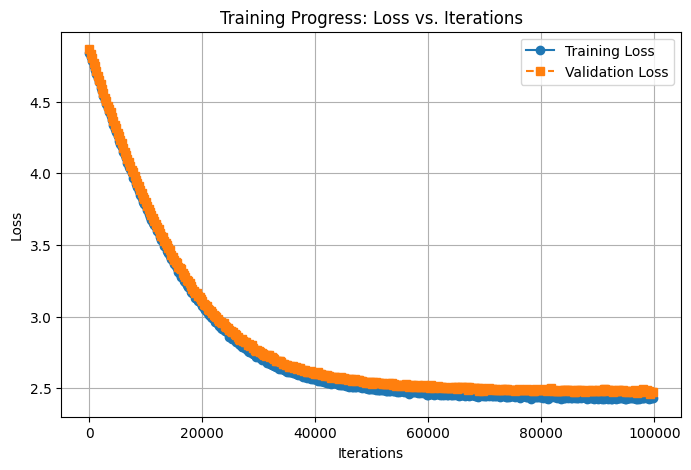

In [9]:
# **Plot the Training Loss Curve**
plt.figure(figsize=(8, 5))
plt.plot(iterations, train_losses, label="Training Loss", marker='o')
plt.plot(iterations, val_losses, label="Validation Loss", marker='s', linestyle="--")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Progress: Loss vs. Iterations")
plt.legend()
plt.grid(True)

# Save the figure (optional)
plt.savefig("training_progress.png")

# Show the plot
plt.show()

In [10]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)



was wenspesppo shen g briconistrde bo tou, nucke
IZed n Haswlenfithambond be askerm Zeabey Jizaly wanend f HNp y s, mey.
t.

pry ttaggsst tha ITote and-th. fembin re bed: oth othe busu se hol burery fun weroofannd to
fl onucthen ce pll.
and th."HEve.
waily soKpeal t we shesheomaccth boror ly."S
"heanefia whe frr. bur or
t ogy thepondin ime acrermu he an.
wacase
" bof meeld, thastoorurd feand Thathothe  S.
ngey bovind s
l ck; th. traten rer tred touthe."Han te oulom aset's ma wat," h th?" ve til


In [11]:
# Find the index of 'T' in the embedding table
start_index = string_to_int['T']  # Convert 'T' to its corresponding index
context = torch.tensor([[start_index]], dtype=torch.long, device=device)
generated_chars = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

The h Wh memoulen thes thy be.

"AU6KSTEut po hes larurin y se ld crun or MOUGuthed ute
s?"
chirg, w.


witf d he
sther; of ld ctun tes


peaurd heson anthedakery y cayend ery. ad as ary boreth loror thige sou'sed chizeig tira aswizas.
[(kspowop, thrdkld mare t tad macecis
y t-whed tw iabus, t cewathekanont ther, aks whocremitizaser watoud the bld tronond d ady
cun e, Zey Jit' eday ss way

e f t wng Eurugotheaty sk-ple in,"Weredocanerthasiocl Wie ginonons me theaknoyowonilathe th he,  eead t THEm
